In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy import integrate
import math as m
import scipy.linalg as la
import scipy.sparse.linalg as sla

In [2]:
k = 9 
_m = 1 
T = 2*m.pi*m.sqrt(k/_m)
omega = 2*m.pi/T 
N = 1e4 
R0 = [0.5, 1.] 
t0, t1 = 0, 5*T 
t = np.linspace(t0, t1, 10000) 
R = np.zeros((len(t), len(R0)))

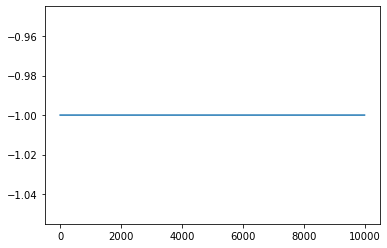

In [3]:
En = np.array([
    1 / 2 * k * R[:, 1][i]**2 + 1 / 2 * _m * R[:, 0][i]**2
    for i in range(len(R[:, 0]))
])
E0 = 1 / 2 * k * R0[1]**2 + 1 / 2 * _m * R0[0]**2
plt.plot(np.linspace(0, len(En), len(En)), (En - E0) / E0)

In [4]:
def oscillator1(t, z):
    omega = 3
    gam = 0.5
    dy = np.zeros(2)
    dy[0] = z[1]
    dy[1] = (-1 * (omega)**2) * z[0] - gam * z[1]

    return dy

In [5]:
def oscillator2(t, z):
    omega = 3
    gam = 0.5
    A0 = 1
    omegaF = 2
    F = A0 * np.cos(omegaF * t)
    dy = np.zeros(2)
    dy[0] = z[1]
    dy[1] = (-1 * (omega)**2) * z[0] - gam * z[1] + F

    return dy

In [6]:
def f1(R0, oscillator):
    N = 1e4
    t0, t1 = 0, 5 * T  # start and end

    t = np.linspace(t0, t1, 10000)
    R = np.zeros((len(t), len(R0)), dtype=np.float64)  # array for solution
    R[0, :] = R0
    r = integrate.ode(oscillator).set_integrator("dopri5")  # choice of method
    r.set_initial_value(R0, t0)  # initial values
    for i in range(1, t.size):
        R[i, :] = r.integrate(t[i])  # get one more value, add it to the array
        if not r.successful():
            raise RuntimeError("Could not integrate")

    fig = plt.figure()
    ax = fig.add_subplot(111)
    surf = ax.plot(t, R[:, 0])

    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    surf1 = ax1.plot(t, R[:, 1])

    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    surf2 = ax2.plot(R[:, 0], R[:, 1])

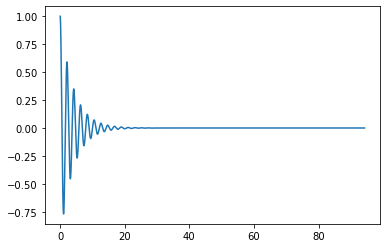

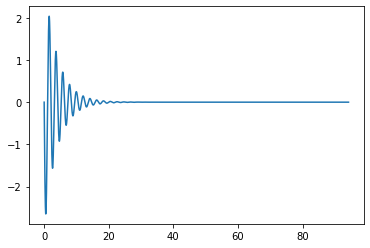

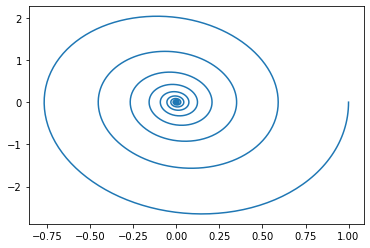

In [7]:
R0 = [1., 0.]
f1(R0, oscillator1)

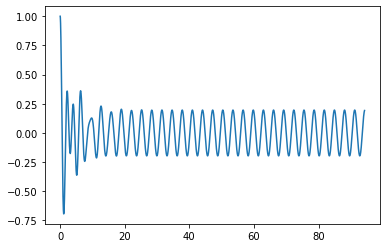

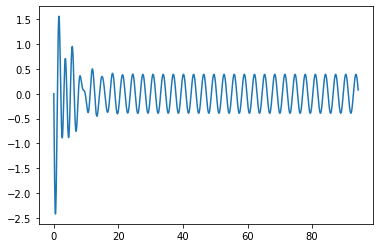

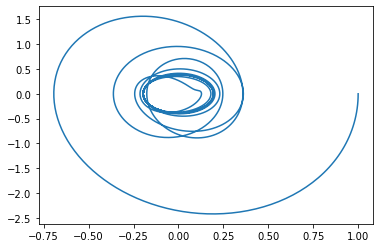

In [8]:
R0 = [1., 0.]
f1(R0, oscillator2)

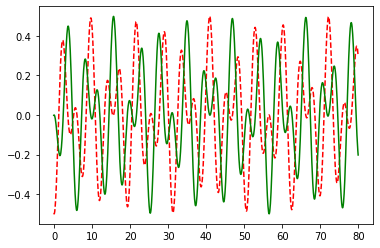

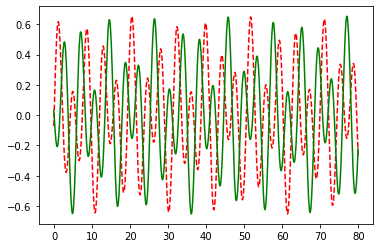

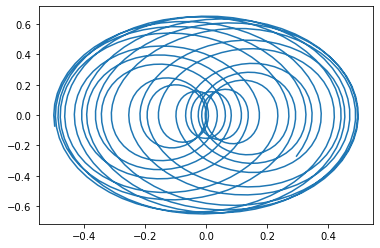

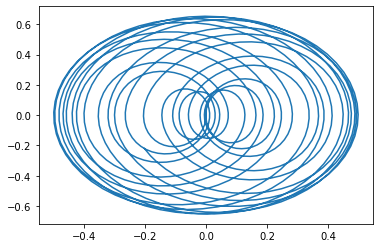

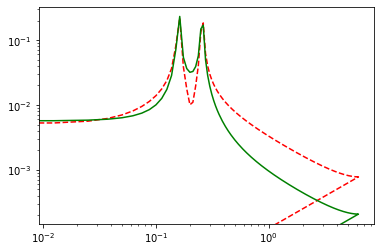

In [9]:
N = 2
_m = [1, 1]
k = [1, 0.8, 1]
R0 = np.array([-0.5, 0])
v0 = np.array([0, 0])

omega = np.zeros((N + 1, N), dtype=np.float64)

for alpha in range(N + 1):
    for beta in range(N):
        omega[alpha, beta] = k[alpha] / _m[beta]

Omega = np.zeros((N, N), dtype=np.float64)

for i in range(N):
    if i == 0:
        Omega[i, i] = omega[0, 0] + omega[1, 0]
        Omega[0, 1] = -omega[1, 0]

    if i > 0:
        if i < N - 1:
            Omega[i, i - 1] = -omega[i, i]
            Omega[i, i] = omega[i, i] + omega[i + 1, i]
            Omega[i, i + 1] = -omega[i + 1, i]
        else:
            Omega[i, i - 1] = -omega[i, i]
            Omega[i, i] = omega[i, i] + omega[i + 1, i]

Theta, Sigma = np.linalg.eig(Omega)

Theta = np.sqrt(Theta)
SigmaV = np.zeros((N, N), dtype=np.float64)

for i in range(N):
    for j in range(N):
        SigmaV[j, i] = -Theta[i] * Sigma[j, i]

C1 = np.dot(np.linalg.inv(Sigma), R0[None].T.conj())
C2 = np.dot(np.linalg.inv(SigmaV), v0[None].T.conj())

C = np.sqrt(C1**2 + C2**2)

alpha = np.zeros(N, dtype=np.float64)

for i in range(N):
    if C[i] == 0:
        alpha[i] = 0
    else:
        alpha[i] = np.arctan(C2[i] / C1[i])

        if C1[i] < 0:
            alpha[i] = m.pi + alpha[i]

        if C1[i] > 0:
            if C2[i] < 0:
                alpha[i] = 2 * m.pi + alpha[i]

N = len(Omega)
N1 = int(1000)
Tmax = 80
t = np.zeros(N1, dtype=np.float64)

X = np.zeros((N, N1), dtype=np.float64)
Xv = np.zeros((N, N1), dtype=np.float64)

for j in range(N1):
    t[j] = (j - 1) / (N1 - 1) * Tmax

for j in range(N1):
    s = np.zeros(N, dtype=np.float64)

    for i in range(N):
        s = s + C[i] * Sigma[:, i] * np.cos(Theta[i] * t[j] + alpha[i])

    X[:, j] = s

for j in range(N1):
    s = np.zeros(N, dtype=np.float64)

    for i in range(N):
        s = s + C[i] * Sigma[:,
                             i] * Theta[i] * np.sin(Theta[i] * t[j] + alpha[i])

    Xv[:, j] = -s

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
p1 = ax1.plot(t, X[0], 'r--', t, X[1], 'g')

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
p2 = ax2.plot(t, Xv[0], 'r--', t, Xv[1], 'g')

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
p3 = ax3.plot(X[0], Xv[0])

fig4 = plt.figure()
ax4 = fig4.add_subplot(111)
p4 = ax4.plot(X[1], Xv[1])

c1 = np.fft.fft(X[0])
c2 = np.fft.fft(X[1])

Cm1 = np.zeros(N1 // 2, dtype=np.float64)
Cm2 = np.zeros(N1 // 2, dtype=np.float64)
Freq = np.zeros(N1 // 2, dtype=np.float64)

for j in range(1, N1 // 2):
    Cm1[j - 1] = abs(c1[j - 1]) / (N1 / 2)
    Cm2[j - 1] = abs(c2[j - 1]) / (N1 / 2)
    Freq[j - 1] = (j - 1) / Tmax

fig6 = plt.figure()
ax6 = fig6.add_subplot(111)
ax6.set_xscale('log')
ax6.set_yscale('log')
p6 = ax6.plot(Freq, Cm1, 'r--', Freq, Cm2, 'g')

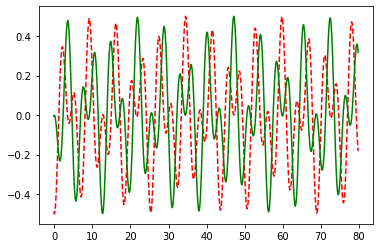

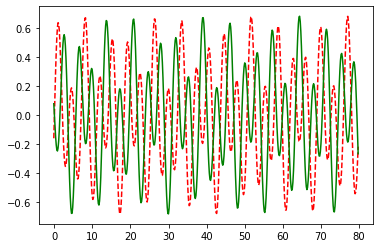

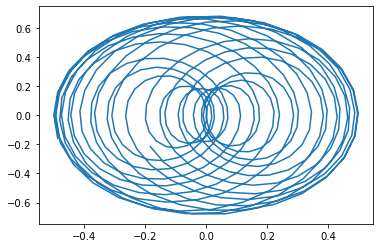

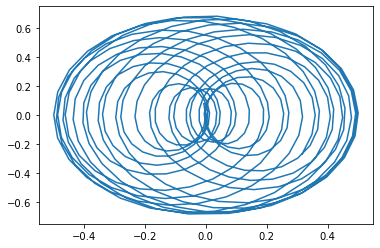

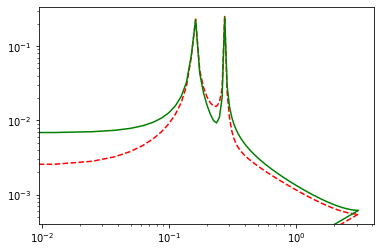

In [10]:
N = 2
_m = [1, 1]
k = [1, 1, 1]
R0 = np.array([-0.5, 0])
v0 = np.array([0, 0])

omega = np.zeros((N + 1, N), dtype=np.float64)

for alpha in range(N + 1):
    for beta in range(N):
        omega[alpha, beta] = k[alpha] / _m[beta]

Omega = np.zeros((N, N), dtype=np.float64)

for i in range(N):
    if i == 0:
        Omega[i, i] = omega[0, 0] + omega[1, 0]
        Omega[0, 1] = -omega[1, 0]

    if i > 0:
        if i < N - 1:
            Omega[i, i - 1] = -omega[i, i]
            Omega[i, i] = omega[i, i] + omega[i + 1, i]
            Omega[i, i + 1] = -omega[i + 1, i]
        else:
            Omega[i, i - 1] = -omega[i, i]
            Omega[i, i] = omega[i, i] + omega[i + 1, i]

Theta, Sigma = np.linalg.eig(Omega)

Theta = np.sqrt(Theta)
SigmaV = np.zeros((N, N), dtype=np.float64)

for i in range(N):
    for j in range(N):
        SigmaV[j, i] = -Theta[i] * Sigma[j, i]

C1 = np.dot(np.linalg.inv(Sigma), R0[None].T.conj())
C2 = np.dot(np.linalg.inv(SigmaV), v0[None].T.conj())

C = np.sqrt(C1**2 + C2**2)

alpha = np.zeros(N, dtype=np.float64)

for i in range(N):
    if C[i] == 0:
        alpha[i] = 0
    else:
        alpha[i] = np.arctan(C2[i] / C1[i])

        if C1[i] < 0:
            alpha[i] = m.pi + alpha[i]

        if C1[i] > 0:
            if C2[i] < 0:
                alpha[i] = 2 * m.pi + alpha[i]

N = len(Omega)
N1 = int(500)
Tmax = 80
t = np.zeros(N1, dtype=np.float64)

X = np.zeros((N, N1), dtype=np.float64)
Xv = np.zeros((N, N1), dtype=np.float64)

for j in range(N1):
    t[j] = (j - 1) / (N1 - 1) * Tmax

for j in range(N1):
    s = np.zeros(N, dtype=np.float64)

    for i in range(N):
        s = s + C[i] * Sigma[:, i] * np.cos(Theta[i] * t[j] + alpha[i])

    X[:, j] = s

for j in range(N1):
    s = np.zeros(N, dtype=np.float64)

    for i in range(N):
        s = s + C[i] * Sigma[:,
                             i] * Theta[i] * np.sin(Theta[i] * t[j] + alpha[i])

    Xv[:, j] = -s

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
p1 = ax1.plot(t, X[0], 'r--', t, X[1], 'g')

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
p2 = ax2.plot(t, Xv[0], 'r--', t, Xv[1], 'g')

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
p3 = ax3.plot(X[0], Xv[0])

fig4 = plt.figure()
ax4 = fig4.add_subplot(111)
p4 = ax4.plot(X[1], Xv[1])

c1 = np.fft.fft(X[0])
c2 = np.fft.fft(X[1])

Cm1 = np.zeros(N1 // 2, dtype=np.float64)
Cm2 = np.zeros(N1 // 2, dtype=np.float64)
Freq = np.zeros(N1 // 2, dtype=np.float64)

for j in range(1, N1 // 2):
    Cm1[j - 1] = abs(c1[j - 1]) / (N1 / 2)
    Cm2[j - 1] = abs(c2[j - 1]) / (N1 / 2)
    Freq[j - 1] = (j - 1) / Tmax

fig6 = plt.figure()
ax6 = fig6.add_subplot(111)
ax6.set_xscale('log')
ax6.set_yscale('log')
p6 = ax6.plot(Freq, Cm1, 'r--', Freq, Cm2, 'g')